In [103]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

fontsize = 14
params = {'axes.labelsize': fontsize,
          'font.size': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'figure.figsize': (15, 8)}
plt.rcParams.update(params)

In [58]:
root_path = os.path.join('..', '..', 'cleaned_logs_to_keep', 'databricks', 'Scala')
full_logs = pd.read_csv(os.path.join(root_path, 'scala_web_google_rdd_df.csv'))

In [59]:
def get_durations(df):
    
    try:
        df['end_of_command'] = pd.to_datetime(df['end_of_command'])
        df['duration'] = df['end_of_command'].diff().dt.total_seconds()
#         df['duration'].fillna(0, inplace=True)
        df.dropna(axis=0, inplace=True)
        df.set_index('loop_counter', inplace=True)
        df['edge_per_node'] = df['filename'].apply(lambda x: int(x.split('_')[-1].split('.')[0]))
    except:
        pass
    return df

In [60]:
rdd_logs = full_logs[full_logs['algo_type'] == 'scala-rdd-sorted']
df_logs = full_logs[full_logs['algo_type'] == 'scala-df']

rdd_logs = get_durations(rdd_logs)
df_logs = get_durations(df_logs)

In [61]:
print(f"duration of rdd version = {rdd_logs['duration'].sum()} seconds")
print(f"duration of df version = {df_logs['duration'].sum()} seconds")

duration of rdd version = 1164.194 seconds
duration of df version = 1245.516 seconds


In [62]:
rdd_logs

,filename,algo_type,command,end_of_command,accum,length,duration
loop_counter,,,,,,,
1,dbfs:/FileStore/web-Google.txt,scala-rdd-sorted,ded_reduce,2021-03-25 16:13:54.701000+00:00,8670951,3265665,64.225
2,dbfs:/FileStore/web-Google.txt,scala-rdd-sorted,ded_reduce,2021-03-25 16:14:56.104000+00:00,4821525,2137152,61.403
3,dbfs:/FileStore/web-Google.txt,scala-rdd-sorted,ded_reduce,2021-03-25 16:15:53.426000+00:00,3278772,2447178,57.322
4,dbfs:/FileStore/web-Google.txt,scala-rdd-sorted,ded_reduce,2021-03-25 16:23:11.339000+00:00,3888454,1805991,437.913
5,dbfs:/FileStore/web-Google.txt,scala-rdd-sorted,ded_reduce,2021-03-25 16:31:15.485000+00:00,1905323,916041,484.146
6,dbfs:/FileStore/web-Google.txt,scala-rdd-sorted,ded_reduce,2021-03-25 16:31:37.109000+00:00,86783,873626,21.624
7,dbfs:/FileStore/web-Google.txt,scala-rdd-sorted,ded_reduce,2021-03-25 16:31:55.614000+00:00,1318,872967,18.505
8,dbfs:/FileStore/web-Google.txt,scala-rdd-sorted,ded_reduce,2021-03-25 16:32:14.670000+00:00,0,872967,19.056


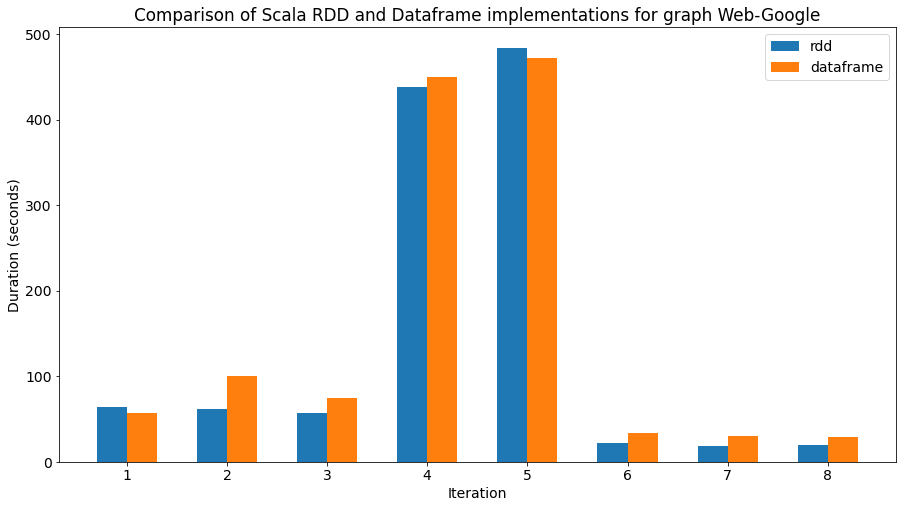

In [63]:
width = 0.3
plt.bar(rdd_logs.index.values - (width / 2), height=rdd_logs['duration'], width=width, label='rdd')
plt.bar(df_logs.index.values + (width / 2), height=df_logs['duration'], width=width, label='dataframe')
plt.xlabel('Iteration')
plt.ylabel('Duration (seconds)')
plt.title('Comparison of Scala RDD and Dataframe implementations for graph Web-Google')
plt.legend()

In [160]:
def plot_graphs(ax, filenames, source, width, param):
    
    rdd_durations = {}
    df_durations = {}

    for i, filename in enumerate(filenames):

        full_logs = pd.read_csv(os.path.join(root_path, filename))

        rdd_logs = full_logs[full_logs['algo_type'] == 'scala-rdd-sorted']
        df_logs = full_logs[full_logs['algo_type'] == 'scala-df']

        rdd_logs = get_durations(rdd_logs)
        df_logs = get_durations(df_logs)

        rdd_durations[source[i]] = rdd_logs['duration'].sum()
        df_durations[source[i]] = df_logs['duration'].sum()
    
    absciss_rdd = np.array(list(rdd_durations.keys())).reshape(-1, 1)
    lin_reg_rdd = LinearRegression()
    lin_reg_rdd.fit(absciss_rdd, list(rdd_durations.values()))
    x_rdd = np.arange(min(rdd_durations.keys()), max(rdd_durations.keys()) + 1)
    y_rdd = x_rdd * lin_reg_rdd.coef_ + lin_reg_rdd.intercept_
    
    absciss_df = np.array(list(df_durations.keys())).reshape(-1, 1)
    lin_reg_df = LinearRegression()
    lin_reg_df.fit(absciss_df, list(df_durations.values()))
    x_df = np.arange(min(df_durations.keys()), max(df_durations.keys()) + 1)
    y_df = x_df * lin_reg_df.coef_ + lin_reg_df.intercept_

    ax.bar([key - (width / 2) for key in rdd_durations.keys()], color='blue', height=rdd_durations.values(), width=width, label='rdd')
    ax.bar([key + (width / 2) for key in df_durations.keys()], color='red', height=df_durations.values(), width=width, label='dataframe')
    ax.plot(x_rdd, y_rdd, 'b--', label=f"intercept={round(lin_reg_rdd.intercept_, 2)}, coef={round(lin_reg_rdd.coef_[0], 4)}")
    ax.plot(x_df, y_df, 'r--', label=f"intercept={round(lin_reg_df.intercept_, 2)}, coef={round(lin_reg_df.coef_[0], 4)}")
    ax.set_ylabel("Total duration (seconds)")
    ax.set_xlabel("Number of " + param)
    ax.legend()

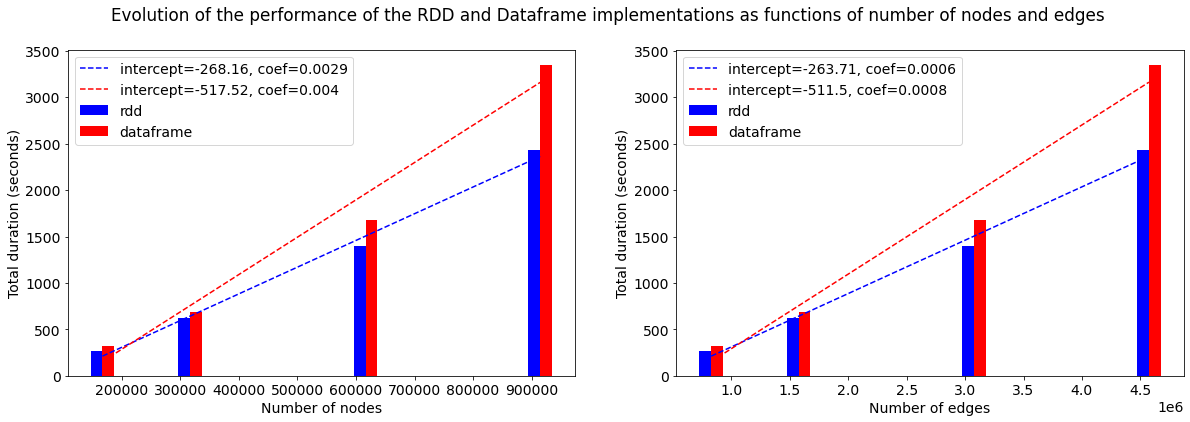

In [163]:
sizes = [10, 20, 40, 60]
nodes = [166_950, 316_202, 616_617, 914_619]
edges = [827_663, 1_577_341, 3_075_032, 4_573_098]

filenames = ["scala_rdd_df_" + str(size) + "M.csv" for size in sizes]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
plot_graphs(ax[0], filenames, nodes, 20_000, "nodes")
plot_graphs(ax[1], filenames, edges, 100_000, "edges")
fig.suptitle("Evolution of the performance of the RDD and Dataframe implementations as functions of number of nodes and edges")
plt.show()